# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.io.sac.sactrace import SACTrace
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter

import matplotlib.colors as mcolors

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET

# Inputs e Outputs

In [2]:
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
MSEED_INPUT = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/DATA_GLIDER_2024/"
LOCAL_EVENTS_TABLE = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/event_files/iag_catalogo_costa.csv"
XML_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/XML/glider_nettab_per_dive.xml'
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
METADATA_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/METADATA/df_campanha_glider.feather'
MODEL_CAKE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/EARTH_MODEL_AREA/model_ak135_mod.nd'
RSBR_STATIONS = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/STA_COORD/estacoes_RSBR_costa.txt'

#FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
#MSEED_INPUT = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA/"
#XML_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/XML/glider_nettab_per_dive.xml'
#METADATA_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/METADATA/df_campanha_glider.feather'
#QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
#MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'
#RSBR_STATIONS = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/STA_COORD/estacoes_RSBR_costa.txt'

# Extraindo informações dos arquivos ".mseed"

In [3]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/GL.*'))

In [4]:
len(filenames_MSEED)

1639

In [5]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]

    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[-1].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[starttime],[endtime]], index=['filename','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [6]:
pandas_mseed_lst = []

with Pool(processes=20) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1639/1639 [03:09<00:00,  8.66it/s]


In [7]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [8]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime,format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime, format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final.sort_values('starttime')


,filename,starttime,endtime
9,GL.G1500..HHH.D.2015.316,2015-11-12 13:48:41,2015-11-12 23:59:59.990
40,GL.G1500..HHH.D.2015.317,2015-11-13 00:00:00,2015-11-13 23:48:28.930
19,GL.G1500..HHH.D.2015.318,2015-11-14 01:22:11,2015-11-14 22:36:02.930
22,GL.G1500..HHH.D.2015.319,2015-11-15 00:00:18,2015-11-15 21:44:28.930
21,GL.G1500..HHH.D.2015.320,2015-11-16 00:11:21,2015-11-16 21:54:52.930
...,...,...,...
1630,GL.G211E..HHH.D.2021.304,2021-10-31 00:18:55,2021-10-31 14:31:12.270
1624,GL.G211E..HHH.D.2021.305,2021-11-01 05:11:58,2021-11-01 13:30:59.780
1632,GL.G211E..HHH.D.2021.306,2021-11-02 02:20:51,2021-11-02 15:18:01.010
1633,GL.G211E..HHH.D.2021.307,2021-11-03 03:38:04,2021-11-03 11:50:10.980


# Extraindo informações do Inventório ".xml"

In [9]:
inv_glider = read_inventory(XML_FILE)

In [10]:
inv_glider

Inventory created at 2024-05-08T01:07:41.161370Z
	Sending institution: scxml import (ObsPy Inventory)
	Contains:
		Networks (1):
			GL
		Stations (45):
			GL.G1500 (RSBR-MAR Station C00:SG618)
			GL.G1601 (RSBR-MAR Station C01:SG618)
			GL.G1602 (RSBR-MAR Station C02:SG612)
			GL.G1604 (RSBR-MAR Station C04:SG612)
			GL.G1605 (RSBR-MAR Station C05:SG612)
			GL.G1606 (RSBR-MAR Station C06:SG612)
			GL.G1607 (RSBR-MAR Station C07:SG612)
			GL.G1608 (RSBR-MAR Station C08:SG612)
			GL.G1709 (RSBR-MAR Station C09:SG612)
			GL.G170A (RSBR-MAR Station C10:SG569)
			GL.G170B (RSBR-MAR Station C11:SG570)
			GL.G170C (RSBR-MAR Station C12:SG569)
			GL.G170E (RSBR-MAR Station C14:SG571)
			GL.G170F (RSBR-MAR Station C15:SG612)
			GL.G170G (RSBR-MAR Station C16:SG612)
			GL.G170H (RSBR-MAR Station C17:SG612)
			GL.G170I (RSBR-MAR Station C18:SG571)
			GL.G170J (RSBR-MAR Station C19:SG612)
			GL.G180K (RSBR-MAR Station C20:SG612)
			GL.G180L (RSBR-MAR Station C21:SG612)
			GL.G180M (RSBR-MAR Statio

In [11]:
df_glider_xml_lst = []
for sta in inv_glider[0]:
    for cha in sta:
        station = sta.code
        latitude = cha.latitude
        longitude = cha.longitude
        depth = cha.depth*(-1)
        starttime = cha.start_date
        endtime = cha.end_date
        df_cha = pd.DataFrame([[station],[latitude],[longitude],[depth],[starttime],[endtime]], index=['station','latitude','longitude','depth','starttime','endtime']).T
        df_glider_xml_lst.append(df_cha)

In [12]:
dataframe_glider_xml = pd.concat(df_glider_xml_lst, ignore_index=True)

In [13]:
dataframe_glider_xml

,station,latitude,longitude,depth,starttime,endtime
0,G1500,-23.8244,-42.4954,-25.43,2015-11-12T13:48:00.000000Z,2015-11-12T13:56:00.000000Z
1,G1500,-23.8166,-42.4944,-49.85,2015-11-12T14:36:00.000000Z,2015-11-12T14:50:00.000000Z
2,G1500,-23.8071,-42.4872,-151.93,2015-11-12T15:35:00.000000Z,2015-11-12T16:15:00.000000Z
3,G1500,-23.7909,-42.4733,-252.44,2015-11-12T17:42:00.000000Z,2015-11-12T18:43:00.000000Z
4,G1500,-23.7852,-42.469,-256.76,2015-11-12T20:43:00.000000Z,2015-11-12T21:47:00.000000Z
...,...,...,...,...,...,...
3772,G211E,-24.3342,-42.434,-472.7,2021-11-02T12:40:00.000000Z,2021-11-02T15:18:00.000000Z
3773,G211E,-24.3568,-42.4256,-480.42,2021-11-03T03:38:00.000000Z,2021-11-03T06:09:00.000000Z
3774,G211E,-24.3784,-42.4306,-477.73,2021-11-03T09:16:00.000000Z,2021-11-03T11:50:00.000000Z
3775,G211E,-24.4377,-42.4649,-434.74,2021-11-04T00:25:00.000000Z,2021-11-04T02:19:00.000000Z


# RSBR SE COAST stations:

In [14]:
RSBR_LOC = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='str')

In [15]:
kstnm = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='str',usecols=1)
stla = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=2)
stlo = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=3)
stel = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=4)

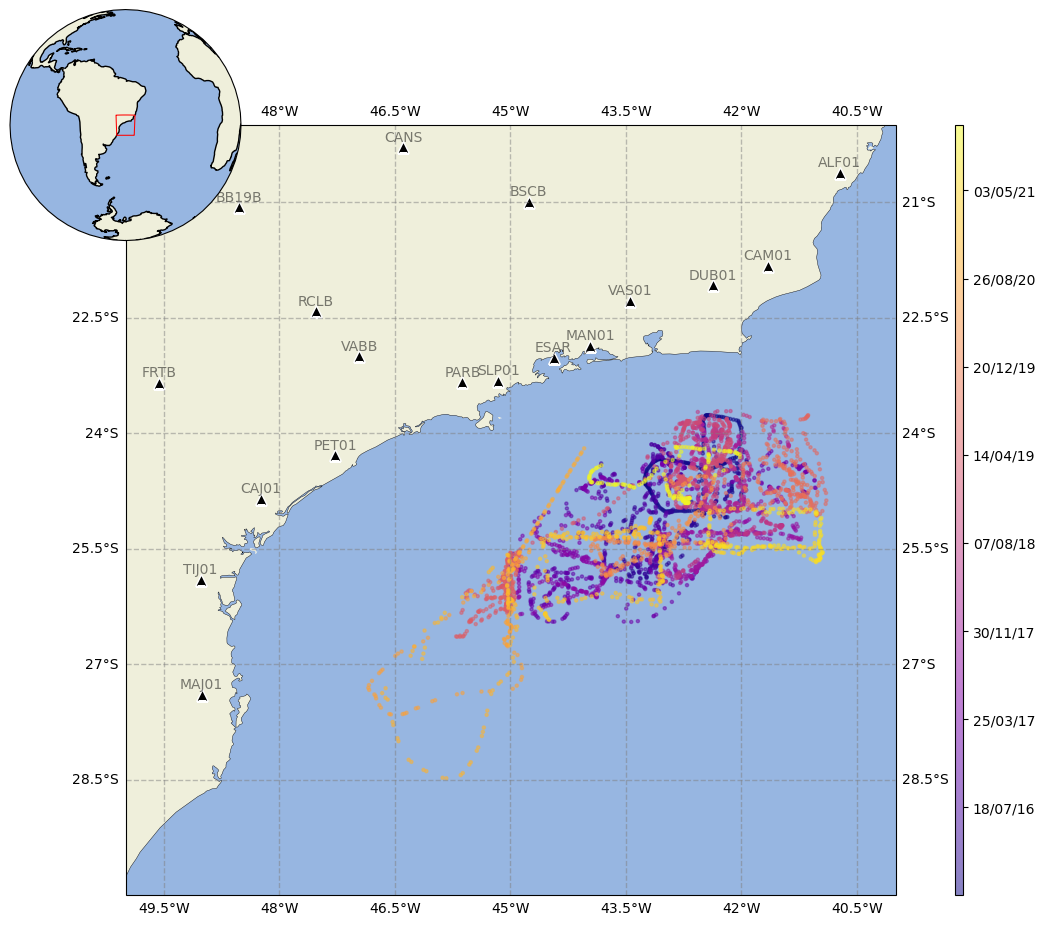

In [16]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='.',alpha=0.5,cmap='plasma',s=20,transform=proj)
ax.scatter(stlo,stla,c='k',marker='^',ec='w',s=70,transform=proj)

# Use the cartopy interface to create a matplotlib transform object
# for the Geodetic coordinate system. We will use this along with
# matplotlib's offset_copy function to define a coordinate system which
# translates the text by 25 pixels to the left.
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)

for lo,la,name in zip(stlo,stla,kstnm):
    if lo < lonmax and lo > lonmin and la > latmin and la < latmax:
        ax.text(lo,la,s=name, verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
  
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax_map = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax_map.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


# Buscando eventos com mecanismos focais através do pyGCMT

In [17]:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS')
cat

781 Event(s) in Catalog:
2021-12-29T18:26:00.000000Z |  -7.690, +127.560 | 7.32 mw
2021-12-26T15:43:01.700000Z | -18.060, -179.360 | 6.14 mw
...
2015-11-07T07:04:41.800000Z | -29.540,  -72.330 | 6.05 mw
2015-11-04T03:44:21.200000Z |  -8.200, +124.950 | 6.54 mw
To see all events call 'print(CatalogObject.__str__(print_all=True))'

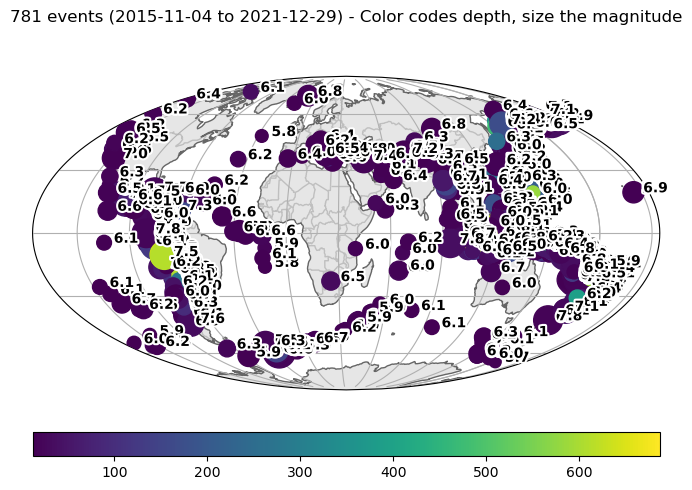

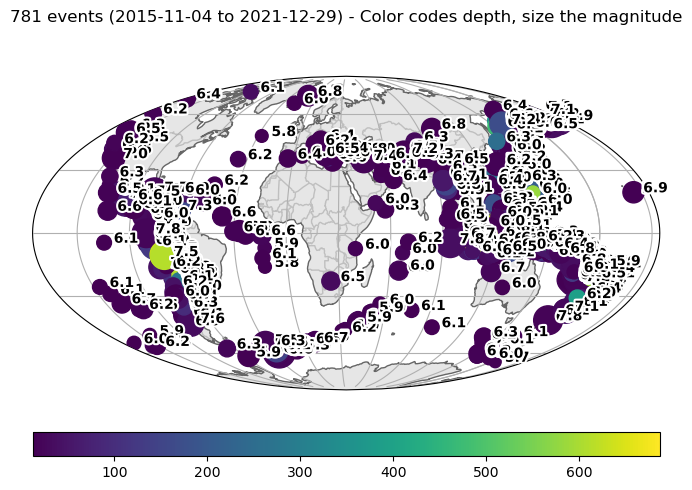

In [18]:
cat.plot()

# PROCURANDO EVENTOS EM FUNÇÃO DO CATÁLOGO 

In [19]:
def classic_sta_lta_py(a, nsta, nlta):
    """
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples. Written in Python by Obspy.
    """
    m = len(a)
    #
    # compute the short time average (STA) and long time average (LTA)
    sta = np.zeros(m, dtype=np.float64)
    lta = np.zeros(m, dtype=np.float64)

    for i in range(m):
        sta[i] = np.mean(a[i:int(i+nsta)]**2)
        lta[i] = np.mean(a[i:int(i+nlta)]**2)

    # Pad zeros
    sta[:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [20]:
def event_search(inpt,CUT_BEFORE=-120,CUT_AFTER=360,FREQ_CFT=3,STA=30,LTA=100,THRON=4,THROFF=3,model_earth='ak135'):
    '''
    Function to search and plot events
    '''   
    ev_file = inpt[0]
    seismic_phase = inpt[1]

    if seismic_phase == 'P':
        CUT_BEFORE = -30
        STA = 5
        LTA = 30
    # =========================================
    # CODE
    
    # Definindo globalmente o tamanho da fonte
    mpl.rcParams.update({'font.size': 12})
  
    ev = ev_file
    
    ev_time = ev.origins[0].time
    ev_lat = ev.origins[0].latitude
    ev_long = ev.origins[0].longitude
    ev_depth = ev.origins[0].depth/1000
    
    file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
    if len(file_mseed_info['filename'].tolist()) > 0:
        name_glider = file_mseed_info['filename'].tolist()[0].split('.')[1]

        # Selecionando no inventório dos glider a localização da estação via ARQUIVO XML:
        inv_sel = inv_glider.select(channel="*H", station=name_glider)
        sta_sel = inv_sel[0][0]
        for cha in sta_sel:
            if (cha.start_date <= ev_time) & (cha.end_date >= ev_time):
                
                #Approximation 
                lat_glider = cha.latitude
                lon_glider = cha.longitude
                dep_glider = cha.depth*-1
                time_glider = cha.start_date

                #Calculating distance, azimuth and backazimuth
                dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
                gcarc = obspy.geodetics.kilometer2degrees(dist/1000)

                # Calculating arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).

                command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str((-1*dep_glider)/1000)+' --distances='+str(gcarc)+' --degrees --classic='+seismic_phase
                proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                (out, err) = proc.communicate()
                results = out.splitlines()
                    
                if len(results) > 3:
                    event = UTCDateTime(ev_time)+float(results[3].split(' ')[2])
                    P_label = seismic_phase
                    
                    #########################################################################################################################################################
                    #STREAM 

                    file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= event.datetime) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= event.datetime)]

                    if len(file_mseed_event) > 0:

                        ev_file_mseed = file_mseed_event['filename'].values[0]
                        file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/'+ev_file_mseed+'*'))[0]

                        stream_mseed = read(file_mseed_ev)
                        stream_mseed = stream_mseed.trim(event+CUT_BEFORE,event+CUT_AFTER)

                        if len(stream_mseed) > 0:

                            # importing the true parameter values of the glider (lon,lat,dep)
                            metadata = pd.read_feather(METADATA_FILE)
                            
                            metadata_sel = metadata[metadata.station_nettab == name_glider]

                            lat_glider_meta = [i for i in metadata_sel["lat"].values[0]]
                            lon_glider_meta = [i for i in metadata_sel["lon"].values[0]]
                            dep_glider_meta = [i*-1 for i in metadata_sel["dep"].values[0]]
                            time_glider_meta = [pd.to_datetime(i) for i in metadata_sel["time"].values[0]]
                            name_glider_df = pd.DataFrame([lat_glider_meta,lon_glider_meta,dep_glider_meta,time_glider_meta], index=['lat_glider','lon_glider','dep_glider','time_glider']).T
            
                            name_glider_df_sel = name_glider_df[(name_glider_df.time_glider >= event+CUT_BEFORE) & (name_glider_df.time_glider <= event+CUT_AFTER)]

                            if len(name_glider_df_sel) > 0:
                                lat_glider = name_glider_df_sel.lat_glider.values[0]
                                lon_glider = name_glider_df_sel.lon_glider.values[0]
                                dep_glider = name_glider_df_sel.dep_glider.values[0]
                                time_glider = name_glider_df_sel.time_glider.values[0]
                                
                            lat_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['latitude'].values
                            lon_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['longitude'].values        
                            depth_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['depth'].values       
                            time_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['starttime'].values        

                            #########################################################################################################################################################
                            #Saving 
                            headerHHH = {
                                        'kstnm': name_glider, 'kcmpnm': 'HHH','knetwk':'GL',
                                        'stla': float(lat_glider), 'stlo': float(lon_glider),'stel': float(dep_glider),
                                        'evdp': float(ev_depth), 'evla': float(ev_lat), 'evlo': float(ev_long), 'mag': float(ev.magnitudes[0].mag),
                                        'nzhour': int(event.hour),'nzjday': int(event.julday), 'nzmin': int(event.minute), 'nzmsec': int('{:03}'.format(event.microsecond)[:3]),'nzsec': int(event.second),'nzyear': int(event.year),
                                        'cmpaz': 0.0, 'cmpinc': 0.0, 'dist': float(dist/1000), 'gcarc': float(gcarc), 'az': float(az), 'baz': float(baz),
                                        't1':float(results[3].split(' ')[2]),'delta':stream_mseed[0].stats.delta
                                        }

                            sacHHH = SACTrace(data=stream_mseed[0].data, **headerHHH)

                           #Creating Event Directory
                            output_sac_data = FOLDER_OUTPUT+'EVENTS_GLIDERS/'+'GL'+'/'+name_glider+'/'+'{:04}'.format(ev_time.year)+'/'+'{:03}'.format(ev_time.julday)+'/'+'{:04}'.format(ev_time.year)+'.'+'{:03}'.format(ev_time.julday)+'.'+'{:02}'.format(ev_time.hour)+'.'+'{:02}'.format(ev_time.minute)+'.'+'{:02}'.format(ev_time.second)+'.'+'{:02}'.format(ev_time.microsecond)[:3]+'/'
                            os.makedirs(output_sac_data,exist_ok=True)
                            sacHHH.write(output_sac_data+'GL'+'.'+name_glider+'.'+'{:04}'.format(ev_time.year)+'.'+'{:03}'.format(ev_time.julday)+'.'+'{:02}'.format(ev_time.hour)+'.'+'{:02}'.format(ev_time.minute)+'.'+'{:02}'.format(ev_time.second)+'.'+'{:02}'.format(ev_time.microsecond)[:3]+'.H')
         
                            #########################################################################################################################################################
                            #Figure 

                            # set up the plot and create a GeoAxes:
                            proj = ccrs.PlateCarree()

                            fig = plt.figure(figsize=(10,20))
                            ax = fig.add_subplot(4, 1, 1, projection=proj)

                            # ----------------------------------------------------------------------------------------------------------
                            # Limit the extent of the map to a small longitude/latitude range.
                            latmin=-27
                            latmax=-22
                            lonmin=-50
                            lonmax=-40

                            ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

                            # ----------------------------------------------------------------------------------------------------------
                            # Ploting lat/lon values

                            h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.5,cmap='plasma',s=25,transform=proj)
                            ax.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                            ax.scatter(stlo,stla,c='k',marker='^',ec='w',s=70,transform=proj)
                            
                            # Use the cartopy interface to create a matplotlib transform object
                            # for the Geodetic coordinate system. We will use this along with
                            # matplotlib's offset_copy function to define a coordinate system which
                            # translates the text by 25 pixels to the left.
                            geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
                            text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)
                            
                            # Add text 25 pixels to the left of the volcano.
                            for lo,la,name in zip(stlo,stla,kstnm):
                                if lo < lonmax and lo > lonmin and la > latmin and la < latmax:
                                    ax.text(lo,la,s=name, verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
                            # ----------------------------------------------------------------------------------------------------------
                            # Adding background map 
                            ax.add_feature(cfeature.LAND)
                            ax.add_feature(cfeature.OCEAN)
                            ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                            ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                            ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

                            #Título
                            ax.set_title(ev.origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Dist: '+str(round(gcarc))+'$^\circ$'+' Dep: '+str(round(ev_depth))+' km'+'\n Mag: '+str(ev.magnitudes[0].mag)+' '+ev.magnitudes[0].magnitude_type+'\n ',y=1.02,fontsize=20)

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding colorbar
                            divider = make_axes_locatable(ax)
                            ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

                            fig.add_axes(ax_cb)
                            cb = plt.colorbar(h, cax=ax_cb)
                            cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

                            #####################################################
                            # Adding inset LAT LON
                            #####################################################

                            axins = plt.axes([0.25, 0.70, 0.1, 0.1],projection=proj)

                            axins.scatter(lon_event_info,lat_event_info,c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in time_event_info]),marker='o',alpha=0.3,cmap='plasma',s=25,transform=proj,vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]))
                            axins.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                            axins.add_feature(cfeature.LAND)
                            axins.add_feature(cfeature.OCEAN)
                            axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                            axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding grid
                            
                            axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                            axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                            # subregion of the original image
                            x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/50)
                            x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/50)
                            y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/50)
                            y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/50)
                            axins.set_xlim(x1, x2)
                            axins.set_ylim(y1, y2)
                            ax.indicate_inset_zoom(axins, edgecolor="black")

                            #####################################################
                            # Adding inset DEPTH LON
                            #####################################################

                            ax_histx = plt.axes([0.25, 0.80, 0.1, 0.05],sharex=axins,facecolor='lightsteelblue')
                            ax_histx.scatter(lon_glider,dep_glider, c=np.array(mdates.date2num(time_glider)),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),alpha=0.5,cmap='plasma',s=100)
                            ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                            ax_histx.set_title("Depth: "+str(round(dep_glider))+' m',fontsize=13)
                            ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                            ax_histx.set_ylim(-1000,0)
                            ax_histx.yaxis.set_major_formatter('{x} m')
                            ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                            ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

                            #####################################################
                            # Adding global location map
                            #####################################################

                            # inset location relative to main plot (ax) in normalized units
                            inset_x = 0
                            inset_y = 1
                            inset_size = 0.4

                            # Adding Geoaxes
                            ax_map = plt.axes([0, 0, 0.5, 0.5], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                            ax_map.set_global()

                            # Adding background map 
                            ax_map.add_feature(cfeature.LAND)
                            ax_map.add_feature(cfeature.OCEAN)
                            ax_map.add_feature(cfeature.COASTLINE)

                            # Adding inset geoaxes position
                            ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                                            inset_y - inset_size / 2,
                                                            inset_size,
                                                            inset_size])
                            ax_map.set_axes_locator(ip)


                            # Adding red rectangle position
                            nvert = 100
                            lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                                 np.linspace(lonmin, lonmax, nvert),
                                                 np.linspace(lonmax, lonmax, nvert)].tolist()
                            lats = np.r_[np.linspace(latmin, latmax, nvert),
                                                 np.linspace(latmax, latmax, nvert),
                                                 np.linspace(latmax, latmin, nvert)].tolist()

                            ring = LinearRing(list(zip(lons, lats)))
                            ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

                            ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                            ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                            ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding stream plot
                            ax1 = fig.add_subplot(4, 1, 2)
                            ax1_HF = ax1.twinx()

                            st_LF = stream_mseed.copy()
                            st_HF = stream_mseed.copy()

                            for tr in st_HF:
                                tr.detrend("linear")
                                tr.taper(max_percentage=0.05, type='cosine')
                                tr.filter('highpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                line_HF, = ax1_HF.plot(tr.times('matplotlib'), tr.data,'grey', lw=2,alpha=0.5,label='> '+str(FREQ_CFT)+' Hz')
                            ax1_HF.legend(handles=[line_HF],loc='lower right', fontsize=10, edgecolor='grey', labelcolor='grey')   

                            for tr in st_LF:
                                tr.detrend("linear")
                                tr.taper(max_percentage=0.05, type='cosine')
                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                line_LF, = ax1.plot(tr.times('matplotlib'), tr.data,'k', lw=1, label='< '+str(FREQ_CFT)+' Hz')
                            ax1.legend(handles=[line_LF],loc='lower left', fontsize=10, edgecolor='k', labelcolor='k')

                            ax1.text(x=event.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                            ax1.set_ylabel('Amplitude [counts]')
                            ax1.set_ylim(-1.5*abs(np.max(st_LF[0].data)),1.5*abs(np.max(st_LF[0].data)))
                            ax1.set_xlim(st_LF[0].times('matplotlib')[0],st_LF[0].times('matplotlib')[-1])
                            locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
                            formatter = mdates.ConciseDateFormatter(locator)
                            ax1.xaxis.set_major_locator(locator)
                            ax1.xaxis.set_major_formatter(formatter)
                            mins2 = SecondLocator(interval=60)
                            mins1 = SecondLocator(interval=10)
                            ax1.xaxis.set_major_locator(mins2)
                            ax1.xaxis.set_minor_locator(mins1)
                            ax1.set_title('Station: '+name_glider)

                            ax1_HF.set_ylim(-1.5*abs(np.max(st_HF[0].data)),1.5*abs(np.max(st_HF[0].data)))
                            ax1_HF.set_xlim(st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1])

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding spectrogram plot
                            ax2 = fig.add_subplot(4, 1, 3,sharex=ax1)

                            fs = stream_mseed[0].stats.sampling_rate  # Frequência de amostragem (100 amostras por segundo)
                            signal_data = stream_mseed[0].data

                            # Spectrogram
                            frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128)

                            # Plot spectrogram
                            im = ax2.imshow(10 * np.log10(Sxx),extent=[st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser')
                            ax2.xaxis.set_major_locator(locator)
                            ax2.xaxis.set_major_formatter(formatter)

                            # ====================================================================
                            ax2.text(x=event.matplotlib_date,y=45,s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax2.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                            ax2.set_ylabel('Frequency [Hz]')

                            # ----------------------------------------------------------------------------------------------------------

                            #colorbar
                            ax_cbar = inset_axes(ax2,
                                                        width="15%",  # width = 15% of parent_bbox width
                                                        height="3%",  # height : 3%
                                                        loc='upper left',
                                                        bbox_to_anchor=(0.0, 0.05, 1, 1),
                                                        bbox_transform=ax2.transAxes,
                                                        borderpad=0,
                                                        )
                            cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal", ticklocation='top')

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding STA/LTA plot
                            ax3 = fig.add_subplot(4, 1, 4,sharex=ax2)

                            st_cft = stream_mseed.copy()

                            for tr in st_cft:
                                tr.detrend("linear")
                                tr.taper(max_percentage=0.05, type='cosine')
                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)

                            ax3.set_title('Absolute Mean Value STA/LTA trigger (< '+str(FREQ_CFT)+' Hz)')
                            ax3.xaxis.set_major_locator(locator)
                            ax3.xaxis.set_major_formatter(formatter)
                            ax3.xaxis.set_major_locator(mins2)
                            ax3.xaxis.set_minor_locator(mins1)
                            ax3.tick_params(axis='both',which='major',width=2,length=5)
                            ax3.tick_params(axis='both',which='minor',width=2,length=3)

                            cft = classic_sta_lta_py(st_cft[0].data, int((STA/2)*st_cft[0].stats.sampling_rate), int((LTA/2)*st_cft[0].stats.sampling_rate))

                            ax3.plot(st_cft[0].times('matplotlib'),cft, 'k')
                            ax3.axhline(THROFF, 0, 1, color='b', linestyle=':')
                            ax3.axhline(THRON, 0, 1, color='g', linestyle=':')
                            ax3.text(x=event.matplotlib_date,y=4.5,s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax3.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                            ax3.set_ylim(0, 5)

                            # ----------------------------------------------------------------------------------------------------------
                            # focal mechanisms
                            # ----------------------------------------------------------------------------------------------------------

                            newax = fig.add_axes([0.7, 0.53, 0.2,  0.2])

                            moment_tensor = ev.focal_mechanisms[0].moment_tensor
                            mrr = moment_tensor.tensor.m_rr
                            mtt = moment_tensor.tensor.m_tt
                            mpp = moment_tensor.tensor.m_pp
                            mrt = moment_tensor.tensor.m_rt
                            mrp = moment_tensor.tensor.m_rp
                            mtp = moment_tensor.tensor.m_tp
                            mt = [mrr, mtt, mpp, mrt, mrp, mtp]

                            bball = beach(fm=mt, xy=(0.5, 0.5),size=200, width=0.75, facecolor='b')

                            # Configura os eixos e adiciona a coleção
                            newax.add_collection(bball)
                            newax.set_xlim(-1, 1)
                            newax.set_ylim(-1, 1)
                            newax.set_aspect('equal')
                            newax.axis('off')

                            # ----------------------------------------------------------------------------------------------------------
                            # ray paths
                            # ----------------------------------------------------------------------------------------------------------
                            model = TauPyModel(model=model_earth)
                            arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=[P_label])
                            ax_raypath = fig.add_axes([0.72, 0.81, 0.13,  0.13], projection='polar')
                            arrivals_ray_path.plot_rays(ax=ax_raypath)

                            # ----------------------------------------------------------------------------------------------------------
                            # Saving figure
                            os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC/'+model_earth+'/'+P_label+'/',exist_ok=True)
                            fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC/'+model_earth+'/'+P_label+'/event_mseed_'+model_earth+'_'+P_label+'_'+ev_time.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_'+ev.event_descriptions[0].text+'.png',pad_inches=0.02,dpi=100)
                            plt.close()

                            # ----------------------------------------------------------------------------------------------------------
                            df = pd.DataFrame([[ev_file_mseed],[name_glider],[P_label],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info']).T

                            return df

In [21]:
fases_sismicas = ["P","PKIKP"]
input_data = []
for fs in fases_sismicas:
    for ev in cat:
        input_data.append([ev,fs])

In [23]:
df_results = []
with Pool(processes=20) as p:
    max_ = len(input_data)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(event_search,input_data):
            df_results.append(result)           
            pbar.update()

 15%|█████████████████████████▋                                                                                                                                                 | 235/1562 [00:04<00:24, 54.27it/s]
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


TypeError: Invalid comparison between dtype=datetime64[ns] and UTCDateTime

Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
Exceptio

In [21]:
dataframe_events_glider = pd.concat(df_results, ignore_index=True)

In [22]:
def round_up_to_base(x, base=25):
    return x + (base - x) % base

In [23]:
dataframe_events_glider['year'] =[UTCDateTime(i).year for i in dataframe_events_glider['ev_time']]
dataframe_events_glider['ev_depth_round'] = dataframe_events_glider['ev_depth'].apply(round_up_to_base)

# FILTRANDO O CATÀLOGO INICIAL EM FUNÇÃO DOS EVENTOS QUE ESTAVAM DENTRO DA JANELA DE DADOS

In [24]:
filtered_catalog = []
for i in dataframe_events_glider.ev_ID.unique():
    for j in cat:
        if i == j.event_descriptions[0].text:
            filtered_catalog.append(j)

In [25]:
len(filtered_catalog)

92

In [26]:
# Obtaining all the parameters from the moment tensor via FMC.py
results_lst = []
for evet in filtered_catalog:
    Exponent_ = 1
    results_lst.append(str(evet.origins[0].longitude)+' '+str(evet.origins[0].latitude)+' '+str(evet.origins[0].depth/1000)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rr)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_pp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tp)+' '
      +str(Exponent_)+' '+' X Y '+evet.event_descriptions[0].text)

In [27]:
file = open('earthquakes_glider.dat','w')
for item in results_lst:
	file.write(item+"\n")
file.close()

In [28]:
os.system('python FMC.py -p '+FOLDER_OUTPUT+'FIGURAS/STATISTICS/Glider_data.pdf earthquakes_glider.dat')

#Longitude Latitude Depth_(km) mrr mtt mff mrt mrf mtf Exponent_(dyn-cm) X_position(GMT) Y_position(GMT) ID rupture_type
-90.58 13.15 34.6 0.985 -0.817 -0.167 0.371 -0.454 0.498 19.0 X Y 202105120845A R
26.44 34.98 24.0 -0.865 -0.839 1.7 1.48 -3.89 0.415 19.0 X Y 202110120924A N
65.53 -17.59 20.2 -0.176 -0.814 0.99 -0.158 0.045 0.384 20.0 X Y 202105121405A SS
-25.01 -60.97 12.0 -3.44 2.0 1.44 1.01 0.401 2.85 19.0 X Y 202007260053A N
-24.85 -60.06 13.0 0.66 0.079 -0.739 0.028 0.663 -0.383 19.0 X Y 202002081432A R
-66.79 18.02 12.0 -3.19 3.42 -0.235 -0.707 -1.5 2.35 19.0 X Y 202001070824A N-SS
-25.69 -59.45 103.9 1.45 -0.349 -1.1 0.798 1.34 -0.496 19.0 X Y 202001200651A R
-114.17 -50.03 12.0 -0.041 0.397 -0.356 -0.013 0.033 0.968 19.0 X Y 201908020550A SS
-27.45 -56.02 57.6 -0.331 1.25 -0.914 -4.04 -4.56 1.11 19.0 X Y 201904051614A N
-27.06 -56.35 82.5 -0.142 0.709 -0.567 -0.365 -0.56 0.901 19.0 X Y 201904221449A SS-R
-35.87 35.26 16.8 -0.078 0.965 -0.887 -0.316 0.223 1.98 19.0 X Y 20190

0

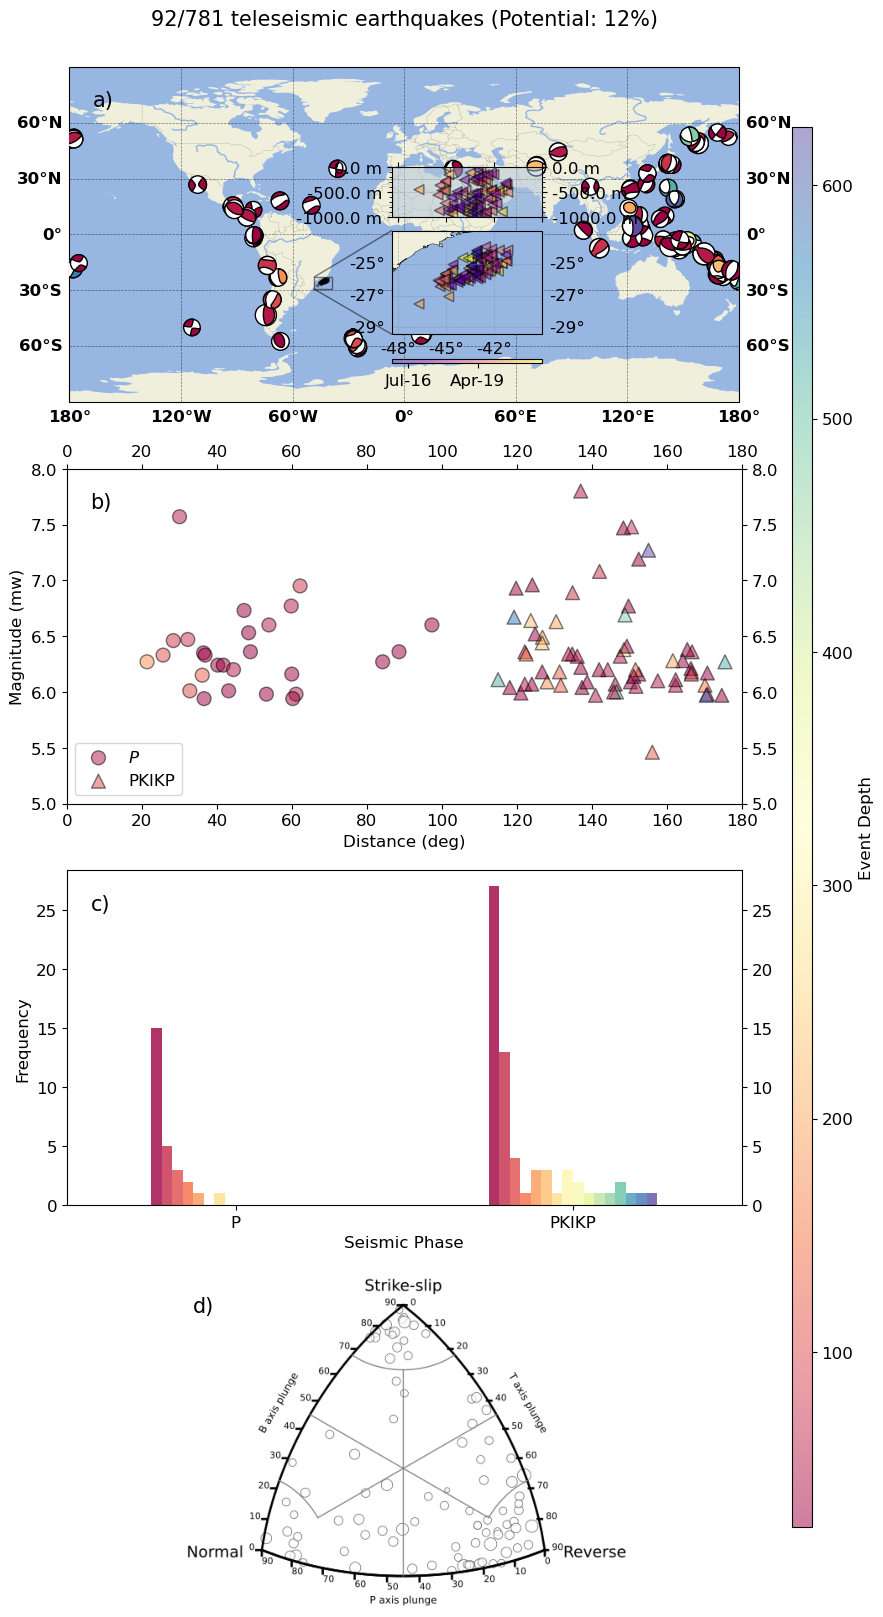

In [62]:
fig = plt.figure(figsize=(10,20))
mpl.rcParams.update({'font.size': 12})

#####################################################
# Adding MAP 
#####################################################

ax = fig.add_subplot(4,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider.ev_depth_round.to_list())
max_val = max(dataframe_events_glider.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.Spectral(value) for value in normalized_values]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider['moment_tensor'])):
    bb = beach(dataframe_events_glider['moment_tensor'].values[i], xy=(dataframe_events_glider['ev_long'].values[i], dataframe_events_glider['ev_lat'].values[i]),facecolor=hex_colors[i],width=dataframe_events_glider['magnitude'].values[i]*1.5, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

ax.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=2.5,transform=proj)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_ylabels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--',lw=0.1)
ax.add_feature(cfeature.RIVERS)
ax.set_title(str(len(filtered_catalog))+'/'+str(len(cat))+' teleseismic earthquakes (Potential: '+str(round(len(filtered_catalog)/len(cat)*100))+'%)',fontsize=15,y=1.1)
ax.text(x=0.05,y=0.9,s='a)',ha="center", va="center",transform=ax.transAxes,fontsize=15)

#####################################################
# Adding inset 
#####################################################

axins = plt.axes([0.45, 0.69, 0.15, 0.15],projection=proj)

h = axins.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50,transform=proj)
axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# subregion of the original image
x1 = np.min(dataframe_glider_xml['longitude'])-abs(np.min(dataframe_glider_xml['longitude'])/30)
x2 = np.max(dataframe_glider_xml['longitude'])+abs(np.max(dataframe_glider_xml['longitude'])/30)
y1 = np.min(dataframe_glider_xml['latitude'])-abs(np.min(dataframe_glider_xml['latitude'])/30)
y2 = np.max(dataframe_glider_xml['latitude'])+abs(np.max(dataframe_glider_xml['latitude'])/30)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
gl = axins.gridlines(crs=ccrs.PlateCarree(),draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)
gl.xlocator = FixedLocator([int(i) for i in np.linspace(x1,x2,num=4)])
gl.ylocator = FixedLocator([int(i) for i in np.linspace(y1,y2,num=4)])
gl.xformatter = LongitudeFormatter(direction_label=False)
gl.yformatter = LatitudeFormatter(direction_label=False)

#####################################################
# Adding inset DEPTH
#####################################################

ax_histx = plt.axes([0.45, 0.805, 0.15, 0.025],sharex=axins,facecolor='lightsteelblue')
ax_histx.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['dep_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50)
ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
ax_histx.set_ylim(-1000,0)
ax_histx.set_xlim(x1, x2)
ax_histx.set_xticks([int(i) for i in np.linspace(x1,x2,num=4)])
ax_histx.yaxis.set_major_formatter('{x} m')
ax_histx.yaxis.set_major_locator(MultipleLocator(500))
ax_histx.yaxis.set_minor_locator(MultipleLocator(100))
ax_histx.patch.set_alpha(0.5)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(axins)
ax_cb = divider.append_axes("bottom",size="4%", pad=0.25, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb,orientation="horizontal")
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.indicate_inset_zoom(axins, edgecolor="black")

#####################################################
# Adding SCATTER PLOT 
#####################################################

ax1 = fig.add_subplot(4, 1, 2)

P_df = dataframe_events_glider[dataframe_events_glider.Phase == "P"]
PKIKP_df = dataframe_events_glider[dataframe_events_glider.Phase == "PKIKP"]

sc1 = ax1.scatter(P_df.distance,P_df.magnitude,marker='o',c=P_df.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5)
sc2 = ax1.scatter(PKIKP_df.distance,PKIKP_df.magnitude,marker='^',c=PKIKP_df.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5)

sc = [sc1,sc2]
ax1.legend(sc,["$P$","PKIKP"], loc='lower left',scatterpoints=1)

ax1.set_xlim(0,180)
ax1.set_ylim(5,8)
ax1.set_xlabel('Distance (deg)')
ax1.set_ylabel('Magnitude (mw)')
ax1.tick_params(axis='both',labelbottom=True, labeltop=True, labelleft=True, labelright=True,bottom=True, top=True, left=True, right=True)
ax1.text(x=0.05,y=0.9,s='b)',ha="center", va="center",transform=ax1.transAxes,fontsize=15)

#####################################################
# Adding HISTOGRAM PLOT 
#####################################################

ax2 = fig.add_subplot(4, 1, 3)
sc4 = pd.crosstab(dataframe_events_glider.Phase, dataframe_events_glider.ev_depth_round).plot.bar(stacked=False,cmap='Spectral',alpha=0.8,ax=ax2,legend=False)
ax2.set_xlabel('Seismic Phase')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', rotation=0, labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.tick_params(axis='y', labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.text(x=0.05,y=0.9,s='c)',ha="center", va="center",transform=ax2.transAxes,fontsize=15)

#####################################################
# Adding FOCAL MECHANISM PLOT 
#####################################################

from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
ax3 = fig.add_subplot(4, 1, 4)
arr_img = plt.imread(FOLDER_OUTPUT+'FIGURAS/STATISTICS/glider_earthquakes_focal_mechanisms_potential.png')
ax3.imshow(arr_img)
ax3.axis('off')
ax3.text(x=0.05,y=0.9,s='d)',ha="center", va="center",transform=ax3.transAxes,fontsize=15)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(sc2, cax=cbar_ax,label='Event Depth',fraction=0.025, shrink= 0.025)

# -------------------------------------------------------------------------------------------------------------------------------------------
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_potential.png',pad_inches=0.025)


# Filtrando o banco de dados em função da análise visual dos resultados:

In [63]:
selected_events = glob.glob(FOLDER_OUTPUT+'FIGURAS/EVENT_SELECTED_TELESEISMIC/*/*')

In [64]:
selected_events_lst = []
selected_events_lst_phase = [] 
for img in selected_events:
    selected_events_lst.append(img.split('/')[-1].split('.')[0].split('_')[-1])
    selected_events_lst_phase.append([img.split('/')[-1].split('.')[0].split('_')[3],img.split('/')[-1].split('.')[0].split('_')[-1]])

In [65]:
selected_events_lst_phase

[['P', '201706140729A'],
 ['P', '202001200651A'],
 ['P', '201810290654A'],
 ['P', '201706221231A'],
 ['P', '201707180205A'],
 ['P', '201611041620A'],
 ['P', '201704150819A'],
 ['PKIKP', '201902171435A'],
 ['PKIKP', '201701100613A'],
 ['PKIKP', '201802251744A'],
 ['PKIKP', '201810131110A'],
 ['PKIKP', '201907111708A'],
 ['PKIKP', '202003250249A']]

In [66]:
selected_events_lst = list(set(selected_events_lst))

In [67]:
len(selected_events_lst)

13

In [68]:
final_catalog = []
for i in selected_events_lst:
    for j in filtered_catalog:
        if i == j.event_descriptions[0].text:
            final_catalog.append(j)

In [69]:
# Obtaining all the parameters from the moment tensor via FMC.py
results_final_lst = []
for evet in final_catalog:
    Exponent_ = 1
    results_final_lst.append(str(evet.origins[0].longitude)+' '+str(evet.origins[0].latitude)+' '+str(evet.origins[0].depth/1000)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rr)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_pp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tp)+' '
      +str(Exponent_)+' '+' X Y '+evet.event_descriptions[0].text)

In [70]:
file = open('earthquakes_glider_final.dat','w')
for item in results_final_lst:
	file.write(item+"\n")
file.close()

In [71]:
os.system('python FMC.py -p '+FOLDER_OUTPUT+'FIGURAS/STATISTICS/Glider_final_data.pdf earthquakes_glider_final.dat')

#Longitude Latitude Depth_(km) mrr mtt mff mrt mrf mtf Exponent_(dyn-cm) X_position(GMT) Y_position(GMT) ID rupture_type
-92.17 14.92 72.7 -1.48 0.845 0.631 2.25 -1.83 -1.1 20.0 X Y 201706140729A N
155.19 -4.66 493.1 -1.11 1.16 -0.054 0.386 -0.21 0.303 19.0 X Y 201907111708A N
-91.38 13.57 38.1 1.66 -1.28 -0.376 0.616 -0.465 0.692 20.0 X Y 201706221231A R
122.78 4.57 621.5 -0.073 0.143 -0.07 0.071 -0.966 0.27 21.0 X Y 201701100613A N
157.87 49.11 52.6 1.96 -0.199 -1.76 0.189 -0.293 -0.815 21.0 X Y 202003250249A R
-67.92 -23.2 164.2 -0.955 -0.444 1.4 0.427 -2.77 -1.02 19.0 X Y 201704150819A N
-73.65 -16.7 66.4 2.89 -6.11 3.22 2.43 -0.983 1.53 19.0 X Y 201707180205A R-SS
-25.69 -59.45 103.9 1.45 -0.349 -1.1 0.798 1.34 -0.496 19.0 X Y 202001200651A R
-70.98 -35.06 96.2 -2.27 -0.487 2.75 -1.74 -2.12 1.01 19.0 X Y 201611041620A N
142.97 -6.29 12.0 1.69 -1.29 -0.4 1.13 -0.255 0.7 21.0 X Y 201802251744A R
152.13 -3.33 372.2 -4.72 3.88 0.837 1.65 -0.223 0.757 19.0 X Y 201902171435A N
153.43 52

0

In [72]:
 dataframe_events_glider_final = dataframe_events_glider[dataframe_events_glider['ev_ID'].isin(selected_events_lst)]

In [73]:
dataframe_events_glider_final

,filename_mseed,name_glider,Phase,ev_ID,ev_time,ev_lat,ev_long,ev_depth,distance,magnitude,...,time_glider,lat_glider,lon_glider,dep_glider,time_dive_info,lat_dive_info,lon_dive_info,depth_dive_info,year,ev_depth_round
6,GL.G2012..HHH.D.2020.020,G2012,P,202001200651A,2020-01-20T06:51:41.500000Z,-59.45,-25.69,103.9,36.125574,6.15,...,2020-01-20 07:03:17.999999,-25.437084,-43.2499,-631.686678,"[2020-01-02T19:56:00.000000Z, 2020-01-02T23:56...","[-25.0276, -25.0456, -25.083, -25.126, -25.201...","[-42.3757, -42.4109, -42.4983, -42.6067, -42.8...","[-378.44, -469.82, -472.92, -474.51, -470.21, ...",2020,125.0
14,GL.G180R..HHH.D.2018.302,G180R,P,201810290654A,2018-10-29T06:54:25.700000Z,-57.55,-66.6,20.7,36.888302,6.33,...,2018-10-29 07:04:52.999997,-24.905491,-42.520976,-932.742894,"[2018-10-04T05:13:00.000000Z, 2018-10-04T11:39...","[-24.904, -24.9463, -24.965, -24.9611, -24.941...","[-42.3447, -42.3455, -42.4091, -42.4414, -42.5...","[-463.37, -457.09, -468.31, -465.28, -463.13, ...",2018,25.0
18,GL.G170E..HHH.D.2017.165,G170E,P,201706140729A,2017-06-14T07:29:07.900000Z,14.92,-92.17,72.7,62.215965,6.95,...,2017-06-14 07:40:56.000002,-26.011126,-43.86674,-259.58467,"[2017-06-03T14:59:00.000000Z, 2017-06-03T21:12...","[-25.5097, -25.5265, -25.5257, -25.5253, -25.5...","[-44.2705, -44.3002, -44.3034, -44.2996, -44.2...","[-26.32, -100.87, -192.06, -298.24, -472.66, -...",2017,75.0
22,GL.G170E..HHH.D.2017.173,G170E,P,201706221231A,2017-06-22T12:31:09.100000Z,13.57,-91.38,38.1,59.852467,6.77,...,2017-06-22 12:42:59.000003,-25.761322,-44.901592,-840.47579,"[2017-06-03T14:59:00.000000Z, 2017-06-03T21:12...","[-25.5097, -25.5265, -25.5257, -25.5253, -25.5...","[-44.2705, -44.3002, -44.3034, -44.2996, -44.2...","[-26.32, -100.87, -192.06, -298.24, -472.66, -...",2017,50.0
23,GL.G170B..HHH.D.2017.105,G170B,P,201704150819A,2017-04-15T08:19:48.300000Z,-23.2,-67.92,164.2,21.397327,6.27,...,2017-04-15 08:25:52.000004,-25.058372,-44.56431,-730.684343,"[2017-03-25T20:27:00.000000Z, 2017-03-26T16:12...","[-24.54, -24.6419, -24.6399, -24.6386, -24.699...","[-43.2156, -43.3151, -43.327, -43.3278, -43.41...","[-473.69, -474.86, -357.35, -476.83, -476.32, ...",2017,175.0
24,GL.G170F..HHH.D.2017.199,G170F,P,201707180205A,2017-07-18T02:05:24.600000Z,-16.7,-73.65,66.4,28.407586,6.46,...,2017-07-18 02:11:13.999999,-25.362501,-44.620017,-844.42001,"[2017-07-13T00:08:00.000000Z, 2017-07-13T05:16...","[-25.6281, -25.6122, -25.6036, -25.5429, -25.5...","[-44.0539, -44.0391, -44.0139, -44.1407, -44.1...","[-477.57, -478.58, -474.14, -474.08, -475.29, ...",2017,75.0
26,GL.G1607..HHH.D.2016.309,G1607,P,201611041620A,2016-11-04T16:20:49.900000Z,-35.06,-70.98,96.2,25.679035,6.33,...,2016-11-04 16:26:24.000005,-25.949465,-43.016092,-50.167189,"[2016-10-21T09:07:00.000000Z, 2016-10-21T18:38...","[-24.6694, -24.689, -24.706, -24.7378, -24.768...","[-42.8876, -42.9289, -42.9354, -42.939, -42.94...","[-25.22, -199.08, -476.84, -476.25, -476.85, -...",2016,100.0
38,GL.G2014..HHH.D.2020.085,G2014,PKIKP,202003250249A,2020-03-25T02:49:32.100000Z,49.11,157.87,52.6,150.590614,7.48,...,2020-03-25 03:07:21.999996,-24.625356,-42.926205,-300.467202,"[2020-03-25T02:07:00.000000Z, 2020-03-25T08:34...","[-24.6254, -24.6498, -24.724, -24.7122, -24.67...","[-42.9124, -42.8853, -42.8503, -42.8233, -42.7...","[-474.82, -468.87, -475.9, -470.61, -470.04, -...",2020,75.0
49,GL.G190X..HHH.D.2019.192,G190X,PKIKP,201907111708A,2019-07-11T17:08:38.800000Z,-4.66,155.19,493.1,146.580679,6.0,...,2019-07-11 17:29:31.999998,-24.828114,-41.172499,-362.526307,"[2019-06-29T15:26:00.000000Z, 2019-06-29T15:54...","[-23.7686, -23.7741, -23.7848, -23.7933, -23.8...","[-41.1344, -41.1398, -41.1442, -41.1539, -41.1...","[-144.77, -15.66, -125.12, -123.52, -119.14, -...",2019,500.0
58,GL.G190U..HHH.D.2019.048,G190U,PKIKP,201902171435A,2019-02-17T14:35:58.100000Z,-3.33,152.13,372.2,148.56927,6.38,...,2019-02-17T13:52:00.000000Z,-24.646,-42.7852,-194.72,"[2019-02-10T14:09:00.000000Z, 2019-02-10T15:41...","

In [74]:
dataframe_events_glider_final_lst = []
for i in selected_events_lst_phase:
    df = dataframe_events_glider[(dataframe_events_glider['ev_ID'] == i[1]) & (dataframe_events_glider['Phase'] == i[0])]
    dataframe_events_glider_final_lst.append(df)

In [75]:
dataframe_events_glider_final = pd.concat(dataframe_events_glider_final_lst, ignore_index=True)

In [76]:
dataframe_events_glider_final.to_csv(FOLDER_OUTPUT+'FIGURAS/STATISTICS/table_events_selected.csv')

In [77]:
dataframe_events_glider_final[dataframe_events_glider_final['Phase'] == 'P']

,filename_mseed,name_glider,Phase,ev_ID,ev_time,ev_lat,ev_long,ev_depth,distance,magnitude,...,time_glider,lat_glider,lon_glider,dep_glider,time_dive_info,lat_dive_info,lon_dive_info,depth_dive_info,year,ev_depth_round
0,GL.G170E..HHH.D.2017.165,G170E,P,201706140729A,2017-06-14T07:29:07.900000Z,14.92,-92.17,72.7,62.215965,6.95,...,2017-06-14 07:40:56.000002,-26.011126,-43.86674,-259.58467,"[2017-06-03T14:59:00.000000Z, 2017-06-03T21:12...","[-25.5097, -25.5265, -25.5257, -25.5253, -25.5...","[-44.2705, -44.3002, -44.3034, -44.2996, -44.2...","[-26.32, -100.87, -192.06, -298.24, -472.66, -...",2017,75.0
1,GL.G2012..HHH.D.2020.020,G2012,P,202001200651A,2020-01-20T06:51:41.500000Z,-59.45,-25.69,103.9,36.125574,6.15,...,2020-01-20 07:03:17.999999,-25.437084,-43.2499,-631.686678,"[2020-01-02T19:56:00.000000Z, 2020-01-02T23:56...","[-25.0276, -25.0456, -25.083, -25.126, -25.201...","[-42.3757, -42.4109, -42.4983, -42.6067, -42.8...","[-378.44, -469.82, -472.92, -474.51, -470.21, ...",2020,125.0
2,GL.G180R..HHH.D.2018.302,G180R,P,201810290654A,2018-10-29T06:54:25.700000Z,-57.55,-66.6,20.7,36.888302,6.33,...,2018-10-29 07:04:52.999997,-24.905491,-42.520976,-932.742894,"[2018-10-04T05:13:00.000000Z, 2018-10-04T11:39...","[-24.904, -24.9463, -24.965, -24.9611, -24.941...","[-42.3447, -42.3455, -42.4091, -42.4414, -42.5...","[-463.37, -457.09, -468.31, -465.28, -463.13, ...",2018,25.0
3,GL.G170E..HHH.D.2017.173,G170E,P,201706221231A,2017-06-22T12:31:09.100000Z,13.57,-91.38,38.1,59.852467,6.77,...,2017-06-22 12:42:59.000003,-25.761322,-44.901592,-840.47579,"[2017-06-03T14:59:00.000000Z, 2017-06-03T21:12...","[-25.5097, -25.5265, -25.5257, -25.5253, -25.5...","[-44.2705, -44.3002, -44.3034, -44.2996, -44.2...","[-26.32, -100.87, -192.06, -298.24, -472.66, -...",2017,50.0
4,GL.G170F..HHH.D.2017.199,G170F,P,201707180205A,2017-07-18T02:05:24.600000Z,-16.7,-73.65,66.4,28.407586,6.46,...,2017-07-18 02:11:13.999999,-25.362501,-44.620017,-844.42001,"[2017-07-13T00:08:00.000000Z, 2017-07-13T05:16...","[-25.6281, -25.6122, -25.6036, -25.5429, -25.5...","[-44.0539, -44.0391, -44.0139, -44.1407, -44.1...","[-477.57, -478.58, -474.14, -474.08, -475.29, ...",2017,75.0
5,GL.G1607..HHH.D.2016.309,G1607,P,201611041620A,2016-11-04T16:20:49.900000Z,-35.06,-70.98,96.2,25.679035,6.33,...,2016-11-04 16:26:24.000005,-25.949465,-43.016092,-50.167189,"[2016-10-21T09:07:00.000000Z, 2016-10-21T18:38...","[-24.6694, -24.689, -24.706, -24.7378, -24.768...","[-42.8876, -42.9289, -42.9354, -42.939, -42.94...","[-25.22, -199.08, -476.84, -476.25, -476.85, -...",2016,100.0
6,GL.G170B..HHH.D.2017.105,G170B,P,201704150819A,2017-04-15T08:19:48.300000Z,-23.2,-67.92,164.2,21.397327,6.27,...,2017-04-15 08:25:52.000004,-25.058372,-44.56431,-730.684343,"[2017-03-25T20:27:00.000000Z, 2017-03-26T16:12...","[-24.54, -24.6419, -24.6399, -24.6386, -24.699...","[-43.2156, -43.3151, -43.327, -43.3278, -43.41...","[-473.69, -474.86, -357.35, -476.83, -476.32, ...",2017,175.0


# FIGURA FINAL com terremotos, análises estatísticas e análise do mecanismo focal

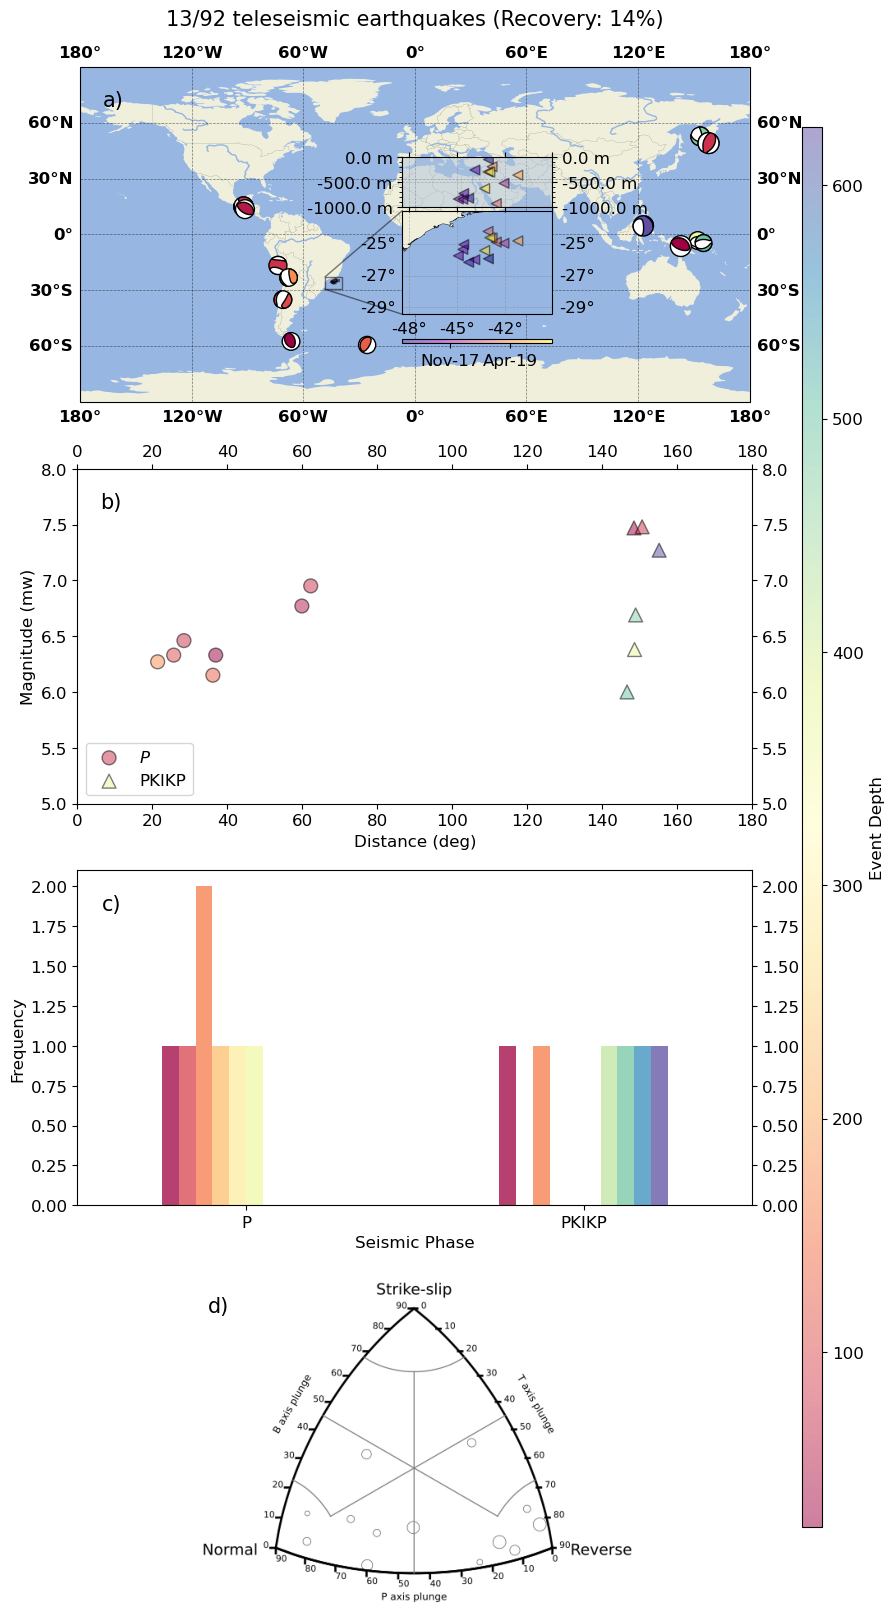

In [78]:
fig = plt.figure(figsize=(10,20))
# Definindo globalmente o tamanho da fonte
mpl.rcParams.update({'font.size': 12})

#####################################################
# Adding MAP 
#####################################################

ax = fig.add_subplot(4,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider_final.ev_depth_round.to_list())
max_val = max(dataframe_events_glider_final.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider_final.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.Spectral(value) for value in normalized_values]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider_final['moment_tensor'])):
    bb = beach(dataframe_events_glider_final['moment_tensor'].values[i], xy=(dataframe_events_glider_final['ev_long'].values[i], dataframe_events_glider_final['ev_lat'].values[i]),facecolor=hex_colors[i],width=dataframe_events_glider_final['magnitude'].values[i]*1.5, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

ax.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=2.5,transform=proj)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.top_xlabels = False
gl.left_ylabels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--',lw=0.1)
ax.add_feature(cfeature.RIVERS)
ax.set_title(str(len(selected_events_lst))+'/'+str(len(filtered_catalog))+' teleseismic earthquakes (Recovery: '+str(round(len(selected_events_lst)/len(filtered_catalog)*100))+'%)',fontsize=15,y=1.1)
ax.text(x=0.05,y=0.9,s='a)',ha="center", va="center",transform=ax.transAxes,fontsize=15)

#####################################################
# Adding inset 
#####################################################

axins = plt.axes([0.45, 0.7, 0.15, 0.15],projection=proj)

h = axins.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50,transform=proj)
axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# subregion of the original image
x1 = np.min(dataframe_glider_xml['longitude'])-abs(np.min(dataframe_glider_xml['longitude'])/30)
x2 = np.max(dataframe_glider_xml['longitude'])+abs(np.max(dataframe_glider_xml['longitude'])/30)
y1 = np.min(dataframe_glider_xml['latitude'])-abs(np.min(dataframe_glider_xml['latitude'])/30)
y2 = np.max(dataframe_glider_xml['latitude'])+abs(np.max(dataframe_glider_xml['latitude'])/30)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
gl = axins.gridlines(crs=ccrs.PlateCarree(),draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)
gl.xlocator = FixedLocator([int(i) for i in np.linspace(x1,x2,num=4)])
gl.ylocator = FixedLocator([int(i) for i in np.linspace(y1,y2,num=4)])
gl.xformatter = LongitudeFormatter(direction_label=False)
gl.yformatter = LatitudeFormatter(direction_label=False)

#####################################################
# Adding inset DEPTH
#####################################################

ax_histx = plt.axes([0.45, 0.81, 0.15, 0.025],sharex=axins,facecolor='lightsteelblue')
ax_histx.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['dep_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50)
ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
ax_histx.set_ylim(-1000,0)
ax_histx.set_xlim(x1, x2)
ax_histx.set_xticks([int(i) for i in np.linspace(x1,x2,num=4)])
ax_histx.yaxis.set_major_formatter('{x} m')
ax_histx.yaxis.set_major_locator(MultipleLocator(500))
ax_histx.yaxis.set_minor_locator(MultipleLocator(100))
ax_histx.patch.set_alpha(0.5)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(axins)
ax_cb = divider.append_axes("bottom",size="4%", pad=0.25, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb,orientation="horizontal")
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.indicate_inset_zoom(axins, edgecolor="black")

#####################################################
# Adding SCATTER PLOT 
#####################################################

ax1 = fig.add_subplot(4, 1, 2)

P_df = dataframe_events_glider_final[dataframe_events_glider_final.Phase == 'P']
PKIKP_df = dataframe_events_glider_final[dataframe_events_glider_final.Phase == 'PKIKP']

sc1 = ax1.scatter(P_df.distance,P_df.magnitude,marker='o',c=P_df.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5)
sc2 = ax1.scatter(PKIKP_df.distance,PKIKP_df.magnitude,marker='^',c=PKIKP_df.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5)

sc = [sc1,sc2]
ax1.legend(sc,["$P$","PKIKP"], loc='lower left',scatterpoints=1)

ax1.set_xlim(0,180)
ax1.set_ylim(5,8)
ax1.set_xlabel('Distance (deg)')
ax1.set_ylabel('Magnitude (mw)')
ax1.tick_params(axis='both',labelbottom=True, labeltop=True, labelleft=True, labelright=True,bottom=True, top=True, left=True, right=True)
ax1.text(x=0.05,y=0.9,s='b)',ha="center", va="center",transform=ax1.transAxes,fontsize=15)

#####################################################
# Adding HISTOGRAM PLOT 
#####################################################

ax2 = fig.add_subplot(4, 1, 3)
sc4 = pd.crosstab(dataframe_events_glider_final.Phase, dataframe_events_glider_final.ev_depth_round).plot.bar(stacked=False,cmap='Spectral',alpha=0.75,ax=ax2,legend=False)
ax2.set_xlabel('Seismic Phase')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', rotation=0,labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.tick_params(axis='y', labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.text(x=0.05,y=0.9,s='c)',ha="center", va="center",transform=ax2.transAxes,fontsize=15)

#####################################################
# Adding FOCAL MECHANISM PLOT 
#####################################################

from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
ax3 = fig.add_subplot(4, 1, 4)
arr_img = plt.imread(FOLDER_OUTPUT+'FIGURAS/STATISTICS/glider_earthquakes_focal_mechanisms.png')
ax3.imshow(arr_img)
ax3.axis('off')
ax3.text(x=0.05,y=0.9,s='d)',ha="center", va="center",transform=ax3.transAxes,fontsize=15)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(sc2, cax=cbar_ax,label='Event Depth',fraction=0.025, shrink= 0.025)

# -------------------------------------------------------------------------------------------------------------------------------------------
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_recorded.png',pad_inches=0.02,dpi=200)


In [79]:
event_local = obspy.read_events(QUAKEXML_FOLDER+'event_2020_03_25_brazil.xml')

/home/sysop/Programs/miniconda3/lib/python3.11/site-packages/obspy/imaging/beachball.py:190: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending of pressure and tension color, see issue #1464.
  warnings.warn(msg)


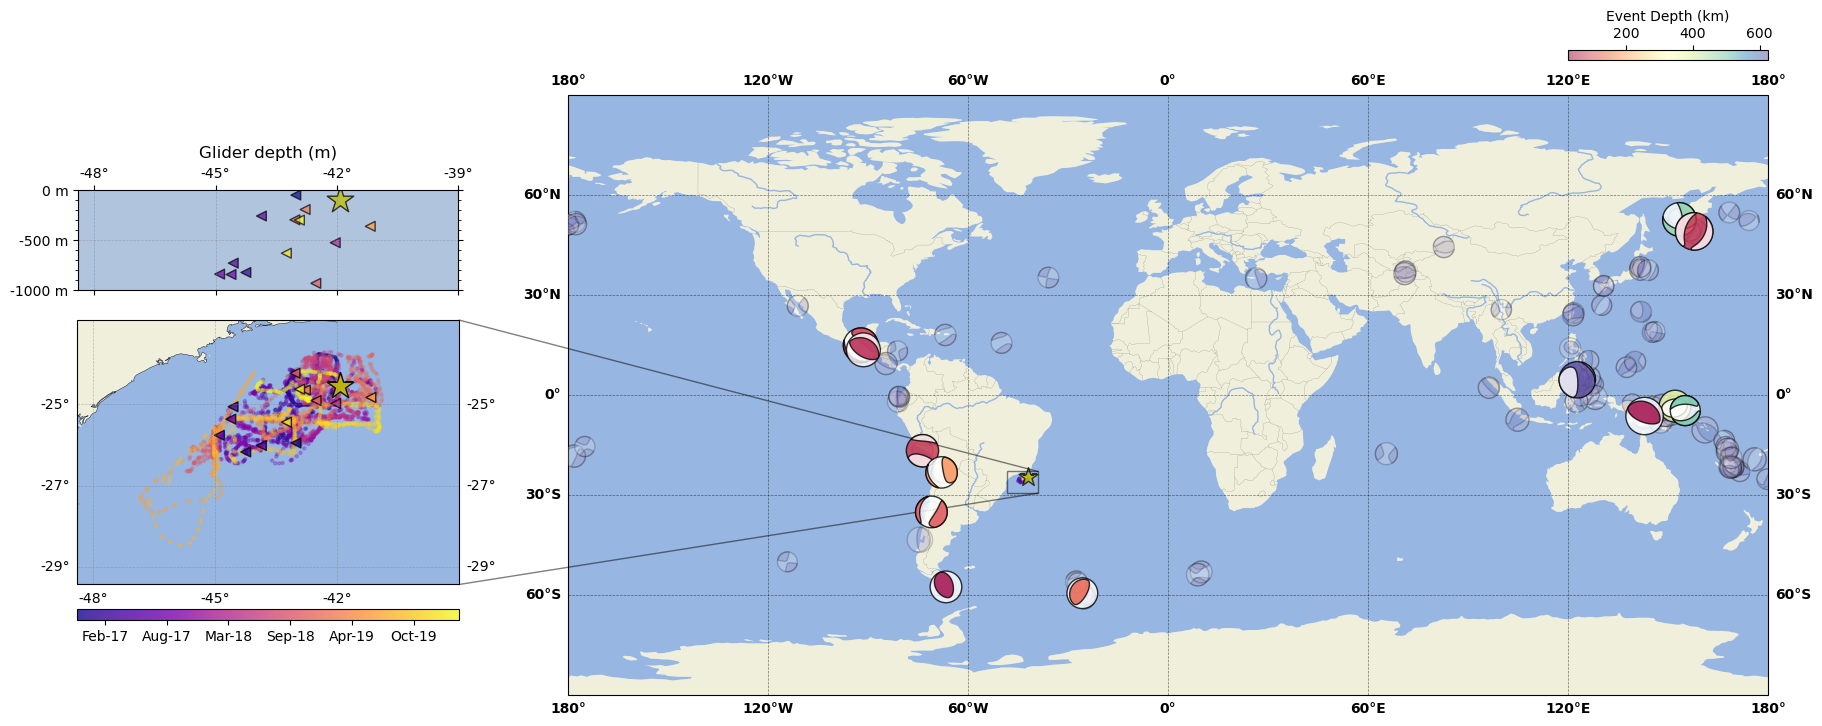

In [80]:
fig = plt.figure(figsize=(20,10))
# Definindo globalmente o tamanho da fonte
mpl.rcParams.update({'font.size': 10})

#####################################################
# Adding MAP 
#####################################################

ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider.ev_depth_round.to_list())
max_val = max(dataframe_events_glider.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.Spectral(value) for value in dataframe_events_glider.ev_depth_round.to_list()]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider['moment_tensor'])):
    bb = beach(dataframe_events_glider['moment_tensor'].values[i], xy=(dataframe_events_glider['ev_long'].values[i], dataframe_events_glider['ev_lat'].values[i]),facecolor=hex_colors[i],width=dataframe_events_glider['magnitude'].values[i],alpha=0.2, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider_final.ev_depth_round.to_list())
max_val = max(dataframe_events_glider_final.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider_final.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.Spectral(value) for value in normalized_values]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider_final['moment_tensor'])):
    bb = beach(dataframe_events_glider_final['moment_tensor'].values[i], xy=(dataframe_events_glider_final['ev_long'].values[i], dataframe_events_glider_final['ev_lat'].values[i]),facecolor=hex_colors[i],width=dataframe_events_glider_final['magnitude'].values[i]*1.5,alpha=0.8, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

im = ax.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker='.',alpha=0.5,cmap='plasma',s=20,transform=proj)

ax.scatter(event_local[0].origins[-1].longitude,event_local[0].origins[-1].latitude,c="y",marker='*',edgecolor='k',alpha=0.75,s=200,transform=proj)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.top_xlabels = False
gl.left_ylabels = False
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--',lw=0.1)
ax.add_feature(cfeature.RIVERS)

fig.subplots_adjust(left=0.3)

#####################################################
# Adding inset 
#####################################################

axins = plt.axes([0.0, 0.27, 0.3, 0.3],projection=proj)

axins.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='.',alpha=0.25,cmap='plasma',s=20,transform=proj)
h = axins.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker='<',alpha=0.8,edgecolor='k',cmap='plasma',s=50,transform=proj)

axins.scatter(event_local[0].origins[-1].longitude,event_local[0].origins[-1].latitude,c="y",marker='*',edgecolor='k',alpha=0.9,s=400,transform=proj)

axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# subregion of the original image
x1 = np.min(dataframe_glider_xml['longitude'])-abs(np.min(dataframe_glider_xml['longitude'])/30)
x2 = np.max(dataframe_glider_xml['longitude'])+abs(np.max(dataframe_glider_xml['longitude'])/30)
y1 = np.min(dataframe_glider_xml['latitude'])-abs(np.min(dataframe_glider_xml['latitude'])/30)
y2 = np.max(dataframe_glider_xml['latitude'])+abs(np.max(dataframe_glider_xml['latitude'])/30)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
gl = axins.gridlines(crs=ccrs.PlateCarree(),draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
gl.xlocator = FixedLocator([int(i) for i in np.linspace(x1,x2,num=4)])
gl.ylocator = FixedLocator([int(i) for i in np.linspace(y1,y2,num=4)])
gl.xformatter = LongitudeFormatter(direction_label=False)
gl.yformatter = LatitudeFormatter(direction_label=False)

#####################################################
# Adding inset DEPTH
#####################################################

ax_histx = plt.axes([0.055, 0.6, 0.19, 0.1],sharex=axins,facecolor='lightsteelblue')
ax_histx.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['dep_glider'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_events_glider_final['time_glider']]),marker="<",edgecolor='k',alpha=0.7,cmap='plasma',s=50)
ax_histx.scatter(event_local[0].origins[-1].longitude,-100,c="y",marker='*',edgecolor='k',alpha=0.75,s=400)
ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax_histx.set_ylim(-1000,0)
ax_histx.set_xlim(x1, x2)
ax_histx.set_xticks([int(i) for i in np.linspace(x1,x2,num=4)])
ax_histx.yaxis.set_major_formatter(StrMethodFormatter("{x:.0f} m"))
ax_histx.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}°"))
ax_histx.yaxis.set_major_locator(MultipleLocator(500))
ax_histx.yaxis.set_minor_locator(MultipleLocator(100))
ax_histx.set_title('Glider depth (m)')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(axins)
ax_cb = divider.append_axes("bottom",size="4%", pad=0.25, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb,orientation="horizontal")
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.indicate_inset_zoom(axins, edgecolor="black")

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
cbar_ax = fig.add_axes([0.8, 0.83, 0.1, 0.01])
cbar = fig.colorbar(sc2, cax=cbar_ax,label='Event Depth (km)',orientation='horizontal',ticklocation='top')

# -------------------------------------------------------------------------------------------------------------------------------------------
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_recorded_location.png',pad_inches=0.02,dpi=200)
